# Biodiversity Intactness Index change in Phoenix subdivision

## Background

## Datasets

- BII data: from MPC STAC catalog
- Phoenix subdivision polygon from Census County Subdivision shapefiles for Arizona

Import libraries and functions

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import contextily as ctx #for adding basemaps

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import pystac_client
import planetary_computer

## Phoenix subdivision

In [3]:
# counties shapefile
az_counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
# phoenix polygon
phx = az_counties[az_counties.NAME == "Phoenix"]

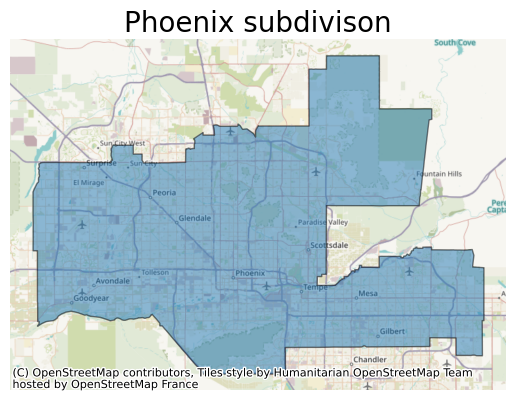

In [4]:
# plot phoenix with geographical context
fig, ax = plt.subplots()

(phx.to_crs(epsg=3857)
 .plot(ax = ax, figsize = (7,7), alpha = 0.5, edgecolor = 'k'))

# add basemap
ctx.add_basemap(ax=ax)

ax.set_title('Phoenix subdivison', fontdict = {'fontsize':'20'})
ax.set_axis_off()

## Biodiversity Intactness Index

In [5]:
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around phoenix
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2017/2020'
)

In [6]:
items = search.item_collection()
items

In [7]:
item_2017 = items[3]
item_2020 = items[0]

In [8]:
phx_17 = rioxr.open_rasterio(item_2017.assets['data'].href)
phx_20 = rioxr.open_rasterio(item_2020.assets['data'].href)

In [10]:
print("phx 2017 bii crs: ", phx_17.rio.crs)
print("phx 2020 bii crs: ", phx_20.rio.crs)
print("phx county crs: ", phx.crs)

phx 2017 bii crs:  EPSG:4326
phx 2020 bii crs:  EPSG:4326
phx county crs:  EPSG:4269


In [12]:
phx = phx.to_crs(phx_17.rio.crs)
# check
print('matched crs?',  phx.crs == phx_17.rio.crs)

matched crs? True


In [ ]:
# clip
# clip rasters to phx
phx_17_clip = phx_17.rio.clip(phx.geometry).squeeze().drop('band')
phx_20_clip = phx_20.rio.clip_box(*phx.total_bounds).squeeze().drop('band')

In [25]:
?phx_17.rio.clip

Signature:
phx_17.rio.clip(
    geometries: collections.abc.Iterable,
    crs: Optional[Any] = None,
    all_touched: bool = False,
    drop: bool = True,
    invert: bool = False,
    from_disk: bool = False,
) -> xarray.core.dataarray.DataArray
Docstring:
Crops a :obj:`xarray.DataArray` by geojson like geometry dicts.

Powered by `rasterio.features.geometry_mask`.

Examples:

    >>> geometry = ''' {"type": "Polygon",
    ...                 "coordinates": [
    ...                 [[-94.07955380199459, 41.69085871273774],
    ...                 [-94.06082436942204, 41.69103313774798],
    ...                 [-94.06063203899649, 41.67932439500822],
    ...                 [-94.07935807746362, 41.679150041277325],
    ...                 [-94.07955380199459, 41.69085871273774]]]}'''
    >>> cropping_geometries = [geojson.loads(geometry)]
    >>> xds = xarray.open_rasterio('cool_raster.tif')
    >>> cropped = xds.rio.clip(geometries=cropping_geometries, crs=4326)


.. versionadded:: 

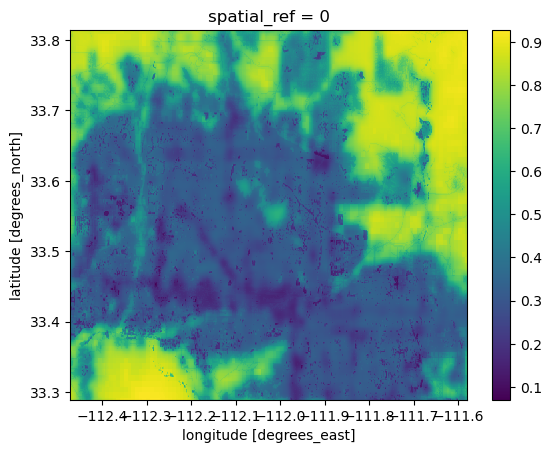

In [20]:
phx_17_clip.plot.imshow()

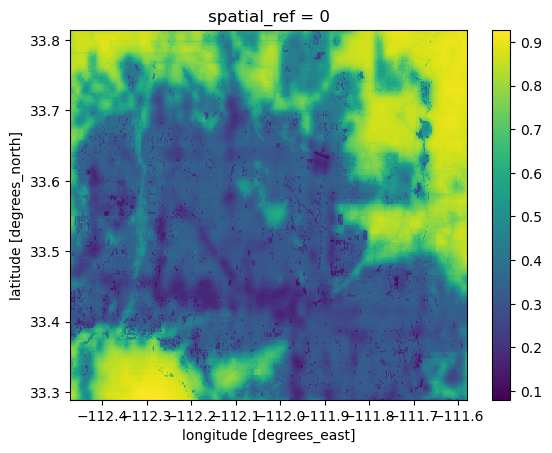

In [22]:
phx_20_clip.plot.imshow()

## Percentage area of phoenix subdivison with BII of at least 0.75 in 2017 and 2020

In [23]:
# calculate change
phx_17_clip - phx_20_clip

<xarray.DataArray (y: 584, x: 992)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.3841858e-07, -2.3841858e-07, -1.7881393e-07],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.3841858e-07, -2.3841858e-07, -2.3841858e-07],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.3841858e-07, -1.7881393e-07, -1.7881393e-07],
       ...,
       [ 2.3208857e-02,  2.5233984e-02,  2.7243495e-02, ...,
         2.8755009e-02,  2.7958333e-02,  2.7308822e-02],
       [ 2.4576962e-02,  2.6638210e-02,  2.8684020e-02, ...,
         2.9238164e-02,  2.7939558e-02,  2.7340412e-02],
       [ 2.6631951e-02,  2.8729260e-02,  3.0811071e-02, ...,
         2.9773355e-02,  2.8623939e-02,  2.8472364e-02]], dtype=float32)
Coordinates:
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0